# Sound Attraction Analysis
This notebook is for comparison of the RW and RepAtt algorithm within a 50m x 50m simulation environment. The purpose of the investigation is to see the differences in navigation of a single robot when it is listening to a single sound source.

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pathlib
from glob import glob
from IPython.display import display
import os

In [21]:
allsoundResults = glob('../results/2019*attraction2sound')
display(allsoundResults)

soundResultPath = allsoundResults[1] + '/'

['../results\\2019-01-31-rectangle-RepAtt-vs-RW-attraction2sound',
 '../results\\2019-02-01-rectangle-RepAtt-vs-RW-attraction2sound']

## Create Readme
My simulations did not create a readme file which I can use to process the different algorithms used to simulate the attraction behaviour. So I need to create one

During this process, I also create a list of IDs that represent the different algorithms

In [22]:
IDList = []
with open(soundResultPath + 'readme2.md','w+') as f:
    for name in glob(soundResultPath + '*robot*'):
        name = name.replace('\\','/')
        name = name.split('/')
        name = name[-1].split('_')
        prefix = name[0]
        algID = prefix.split('-')
        algID = '-'.join(algID[1:-7])
        lineData = 'prefix:{},ID:{}\n'.format(prefix,algID)
        IDList.append(algID)
        f.write(lineData)
uniqIDs = pd.Series(IDList).unique()


## Create DataFrames

We will need dataframe that represents the logged data and dataframe to hold all instances of a particular parameter of interest for different simulation counts of a particular algorithm

In [23]:
def beacon_distance_plots(algIDsims,timeList,analysisFolder,ID):
    f = plt.figure()
    algIDsims.plot(ax=f.gca(),color=colors)
    plt.legend().set_visible(False)
    plt.xlabel('Time in Seconds')
    plt.ylabel('Distance in metres')
    plt.ylim([0, 15])
    plt.xticks(np.linspace(min(timeList),max(timeList),10))
    f.savefig(analysisFolder + ID + '.pdf', bbox_inches='tight')
#     plt.title(ID)
#     display(ID,algIDsims)
#     plt.legend().set_visible(True)
    
    plt.close()

In [24]:
def beacon_distance_analysis_plot(algIDsims,analysisFolder):
    colors = plt.cm.jet(np.linspace(0,1,len(algIDsims['Mean'].index))) # 30 different colors for 30 simulations per algorithm
    for cl in algIDsims['Mean'].columns:
        if 'Noise' in cl:
            col = cl.split('-')
            N = int(re.findall('\d+',col[1])[0])
            Q = int(re.findall('\d+',col[2])[0])
            col = '{}-N{:03d}-Q{:02d}'.format(col[0],N,Q)
            algIDsims['Mean'].rename(columns={cl:col},inplace=True)
            algIDsims['STD'].rename(columns={cl:col},inplace=True)
        
    algIDsims['Mean'] = algIDsims['Mean'].transpose()
    algIDsims['Mean'] = algIDsims['Mean'].sort_index()
    
    algIDsims['STD'] = algIDsims['STD'].transpose()
    algIDsims['STD'] = algIDsims['STD'].sort_index()
    
    algIDsimsLatex = pd.DataFrame(index=algIDsims['Mean'].index,
                                 columns=algIDsims['Mean'].columns)
#     display(algIDsimsLatex)
#     display(algIDsims['STD'])
#     display(algIDsims['Mean'])
    for ind in algIDsims['Mean'].index:
        
        for col in algIDsims['Mean'].columns:
#             print(ind,col)
            algIDsimsLatex.loc[ind,col] = \
            '${:.2f} \pm {:.2f}$'.format(algIDsims['Mean'].loc[ind,col],
                                         algIDsims['STD'].loc[ind,col])
   
    algIDsimsLatex.to_latex(analysisFolder + 'beacon_distance.tex',
                           encoding='utf-8', escape=False)
    f = plt.figure()
    algIDsims['Mean'].plot(kind='bar',ax = f.gca(),color=colors,stacked=True)
    plt.legend(loc='center left',bbox_to_anchor=(1,0.5),title='Distance').set_visible(True)
    plt.ylabel('Time in Seconds')
    plt.xlabel('Algorithms')
    f.savefig(analysisFolder + 'beacon_distance.pdf', bbox_inches='tight')
    


'RepAtt-Noise0pct-qsize1'

29

'RepAtt-Noise100pct-qsize40'

29

'RW-0p0025P'

29

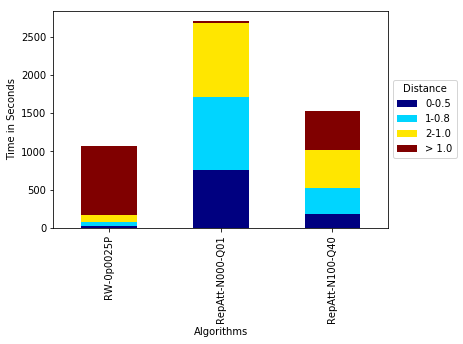

In [25]:
analysisFolder = soundResultPath + 'sound_analysis/'
pathlib.Path(analysisFolder).mkdir(parents=False,exist_ok=True)

logCSVcols = ['name', 'Time', 'xc', 'yc', 'theta', 'turn_prob', 'beacon_distance',
          'rep_neigh','rep_signal','call_neigh','call_signal','linear_dist',
          'rot_dist','wall_bounces','t_obstacle_avoidance','action','state']
timeList = [] # needed to keep list of time steps
colors = plt.cm.jet(np.linspace(0,1,30)) # 30 different colors for 30 simulations per algorithm

maxDbound = [0.5, 0.8, 1.0]
boundRange = ['{}-{}'.format(i,j) for i,j in enumerate(maxDbound)]
boundRange.append('> {}'.format(maxDbound[-1]))
maxDbound = np.append(maxDbound,np.Inf)

allIDdists = {'Mean': pd.DataFrame(index=boundRange),
             'STD': pd.DataFrame(index=boundRange)}

for ID in uniqIDs:
    algIDsims = pd.DataFrame() #dataframe to keep each simulation as column
    algIDdist = pd.DataFrame(index=boundRange)
    sim = 0
    for sim,simTime in enumerate(glob(soundResultPath + '*' + ID + '*')):
        simData = pd.read_csv(simTime,header = None, sep = ':|,',
                              engine='python', names = logCSVcols)
#         display(simData)
        if len(simData['Time']) > len(timeList):#keep track of longest rows
            timeList = simData['Time']
        algIDsims[sim] = simData['beacon_distance']
        
        for mDbound,ind in zip(maxDbound,boundRange):
            if mDbound == np.Inf:
                minDbound = maxDbound[-2]
            else:
                minDbound = mDbound - 1
                
            algIDdist.loc[ind,sim] = len(algIDsims[sim].loc[
                    (algIDsims[sim] >= minDbound)  & 
                    (algIDsims[sim] <= mDbound)
                ])
    allIDdists['Mean'][ID] = algIDdist.mean(axis=1)
    allIDdists['STD'][ID] = algIDdist.std(axis=1)
    beacon_distance_plots(algIDsims,timeList.values,analysisFolder,ID)
    display(ID,sim)

#plot analysis of all the algorithm's distance from the beacon
beacon_distance_analysis_plot(allIDdists,analysisFolder)




In [27]:
allIDdists['Mean'].sum(axis=1)

RW-0p0025P         1076.800000
RepAtt-N000-Q01    2705.166667
RepAtt-N100-Q40    1526.566667
dtype: float64

In [34]:
maxDbound = np.arange(5) + 1
boundRange = ['{}-{}'.format(i,j) for i,j in enumerate(maxDbound)]
boundRange.append('> {}'.format(maxDbound[-1]))
boundRange
np.append(maxDbound,900)

array([  1,   2,   3,   4,   5, 900])